Importación de librerías

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


Preparamos el dataset y dataloaders

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Dataset con carpetas 'sano' y 'plaga'
train_dataset = datasets.ImageFolder("Dataset/train", transform=transform)
test_dataset = datasets.ImageFolder("Dataset/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

classes = train_dataset.classes
print("Clases detectadas:", classes)


Clases detectadas: ['plaga', 'sano']


Definimos el modelo MLP

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size=(3, 128, 128), num_classes=2):
        super(MLPModel, self).__init__()
        flattened_size = input_size[0] * input_size[1] * input_size[2]
        self.fc1 = nn.Linear(flattened_size, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


Definimos el modelo CNN

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Realizamos la funcionn para entrenar y evaluar el modelo

In [ ]:
def train_model(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

    # Evaluación
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    acc = accuracy_score(y_true, y_pred)
    return acc


Entrenamiento del modelo MLP


In [ ]:
mlp = MLPModel(input_size=(3,128,128), num_classes=len(train_dataset.classes))
acc_mlp = train_model(mlp, train_loader, test_loader, epochs=10)
print(f"Accuracy MLP: {acc_mlp*100:.2f}%")


Epoch [1/10], Loss: 196.1493
Epoch [2/10], Loss: 89.2152
Epoch [3/10], Loss: 91.5298
Epoch [4/10], Loss: 84.8351
Epoch [5/10], Loss: 82.2677
Epoch [6/10], Loss: 91.8832
Epoch [7/10], Loss: 89.2104
Epoch [8/10], Loss: 87.3525
Epoch [9/10], Loss: 81.3532
Epoch [10/10], Loss: 86.8796
Accuracy MLP: 68.42%


Entrenamiento del modelo cnn

In [ ]:
cnn = CNNModel()
acc_cnn = train_model(cnn, train_loader, test_loader, epochs=15)
print(f"Accuracy CNN: {acc_cnn*100:.2f}%")


Epoch [1/15], Loss: 80.8903
Epoch [2/15], Loss: 64.7620
Epoch [3/15], Loss: 59.4308
Epoch [4/15], Loss: 51.1808
Epoch [5/15], Loss: 44.4130
Epoch [6/15], Loss: 32.4277
Epoch [7/15], Loss: 25.1565
Epoch [8/15], Loss: 16.2857
Epoch [9/15], Loss: 10.0933
Epoch [10/15], Loss: 10.8138
Epoch [11/15], Loss: 7.9707
Epoch [12/15], Loss: 6.3487
Epoch [13/15], Loss: 5.2506
Epoch [14/15], Loss: 6.1088
Epoch [15/15], Loss: 1.1327
Accuracy CNN: 83.77%


Mostramos la prediccion de un ejemplo del dataset

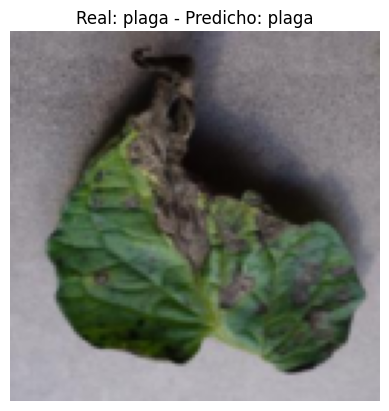

In [ ]:
def show_prediction(model, dataset, idx=0):
    image, label = dataset[idx]
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        _, pred = torch.max(output, 1)
    plt.imshow(image.permute(1,2,0))
    plt.title(f"Real: {classes[label]} - Predicho: {classes[pred.item()]}")
    plt.axis("off")
    plt.show()

# Ejemplo con CNN
show_prediction(cnn, test_dataset, idx=0)


Con este ejemplo vemos que El CNN es mejor que el MLP para clasificar estas imágenes porque:

🔹 Conserva la estructura de la imagen: usa convoluciones que detectan bordes, texturas y formas, mientras que el MLP aplana la imagen y pierde esa información espacial.

🔹 Menos parámetros y mejor generalización: los filtros de la CNN se reutilizan en toda la imagen, haciendo el modelo más eficiente y menos propenso al sobreajuste que un MLP con miles de pesos.

🔹 Mejor desempeño en visión por computadora: en la práctica, un CNN suele alcanzar un accuracy mucho más alto que un MLP en datasets de imágenes.